Inference:https://www.heywhale.com/mw/project/5d2ee122688d36002c657985
- Transformer 是 Google 团队在 17 年 6 月提出的 NLP 经典之作，
由 Ashish Vaswani 等人在 2017 年发表的论文 Attention Is All You Need 中提出。
Transformer 在机器翻译任务上的表现超过了 RNN，CNN，只用 encoder-decoder 和 attention 机制就能达到很好的效果。其最大的优点是可以高效地并行化，从而克服RNN速度慢的缺点。


## 一. 总览
首先我们看一下Transformer的整体框架。
[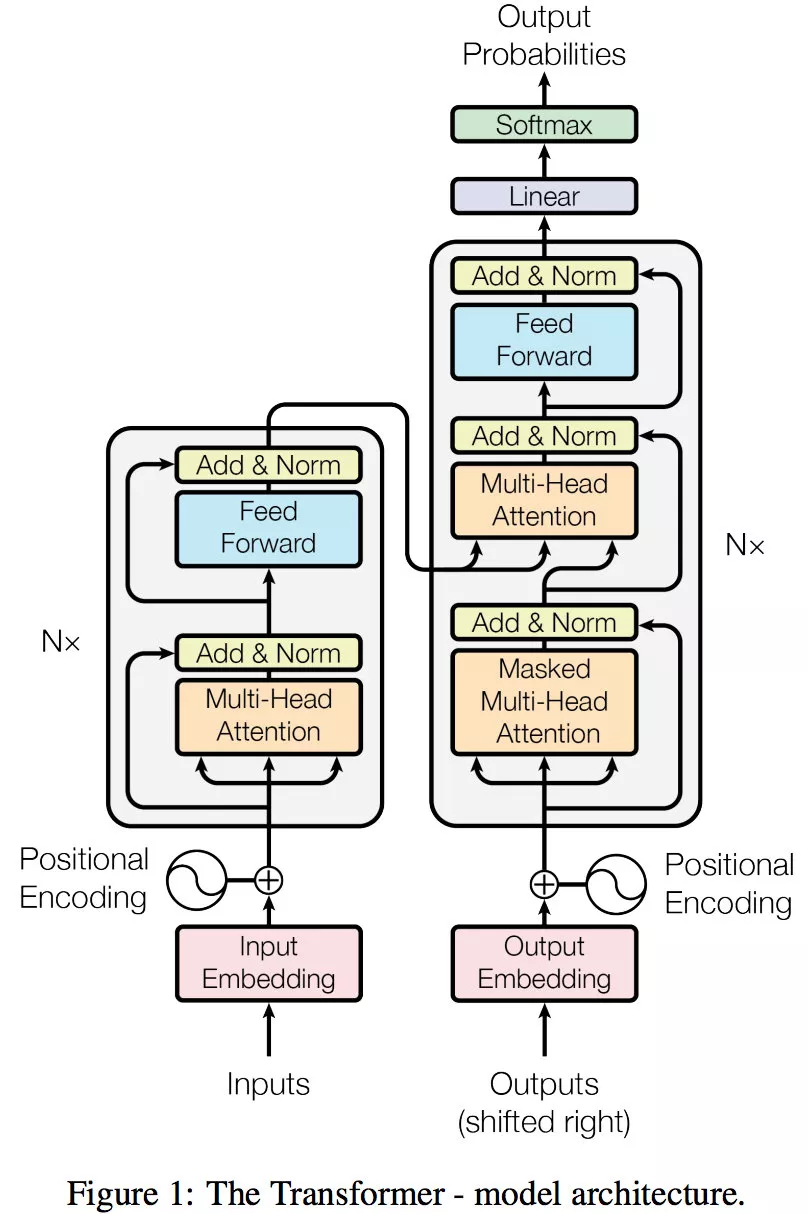](https://mmbiz.qpic.cn/mmbiz_jpg/KSFwdL2dV7adibgicwdictrSLmF2ibaSZlibibTUZKNpRfcNkkUMHcNibbm0XxyHrWHKAKzvknTswLGYMgHfUg3Z4ibsoQ/640?wx_fmt=jpeg&tp=webp&wxfrom=5&wx_lazy=1&wx_co=1)



Transformer和传统的seq2seq模型类似，主要由两部分构成：Encoder和Decoder。

[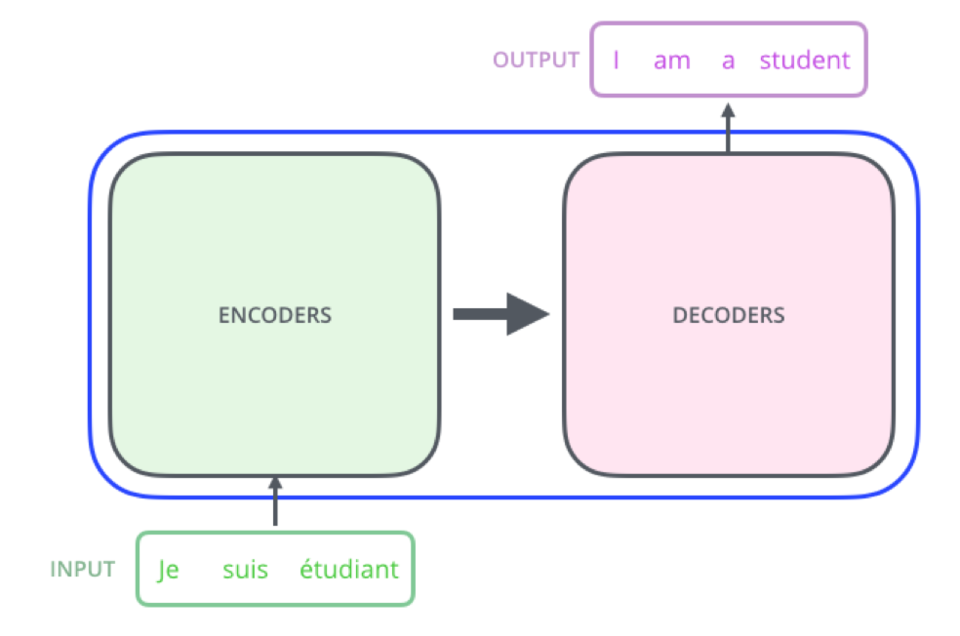](https://cdn.kesci.com/upload/image/puvotx965y.png?imageView2/0/w/960/h/960)


那么encoders和decoders是怎么结合的呢？我们先看下面这张图。我们可以看到，Encoder的每一层的输出都会和decoder进行结合。
[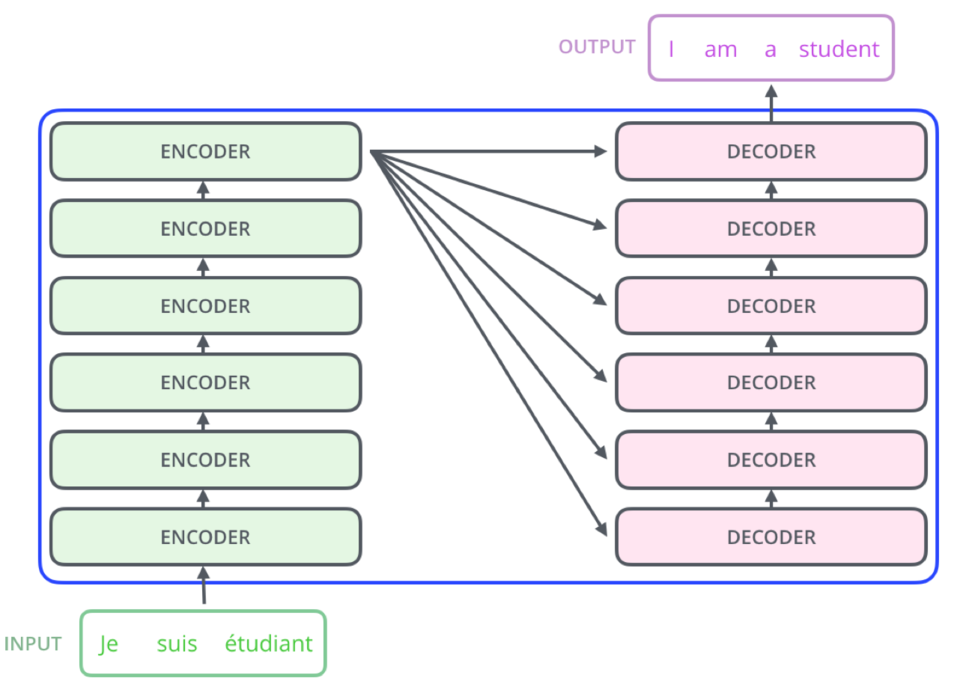](https://cdn.kesci.com/upload/image/puvp0gznz7.png?imageView2/0/w/960/h/960)


## 二.准备
我们先确定一些基础变量，方便后面的代码实现。

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

dtype = torch.FloatTensor

S: symbol that shows starting of decoding input

E: symbol that shows starting of decoding output

P: symbol that will fill in blank sequence if current batch data size is shorter than time step

未来方便运行，我们只采用了一句话。

In [2]:
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

定义我们的字典映射，确定句子的长度。

In [3]:
# Transformer parameters
# Padding should be zero
src_vocab = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'bier': 4}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P' : 0, 'i' : 1, 'want' : 2, 'a' : 3, 'beer' : 4, 'S' : 5, 'E' : 6}
number_dict = {i:w for w, i in tgt_vocab.items()}
tgt_vocab_size = len(tgt_vocab)

In [4]:
src_len = 5
tgt_len = 5

这里定义了几个比较重要的参数：
- 词嵌入的维度：512
- 全连接前向网络的输出维度：2048。（在进行了Attention操作之后，encoder和decoder中的每一层都包含了一个全连接前向网络）
- K、Q、V的维度
- 调用多少个Encoderlayer和Decoderlayer。论文中使用了6个。
- Multi-head attention的数目。论文中为8个

In [5]:
d_model = 512 # Embedding size
d_ff = 2048 # FeedForward dimension
d_k = d_v = 64 # dimension of K, Q, V
n_layers = 6 # number of encoder and decoder layers
n_heads = 8 # number of heads in Multi-Head Attention

## 三. 定义Transformer的部件
1.首先我们输入、输出等。

In [6]:
def make_batch(sentences):
    input_batch = [[src_vocab[w] for w in sentences[0].split(" ")]]
    output_batch = [[tgt_vocab[w] for w in sentences[1].split(" ")]]
    target_batch = [[tgt_vocab[w] for w in sentences[2].split(" ")]]
    return Variable(torch.LongTensor(input_batch)), Variable(torch.LongTensor(output_batch)), Variable(torch.LongTensor(target_batch))

2.Positional Encoding

Transformer由于没有使用RNN等的结构，丢失了句子单词的前后关系，即如果我们将一句句子顺序打乱，Transformer的结果会一样。因此我们需要通过Position Embedding来弥补这一点。
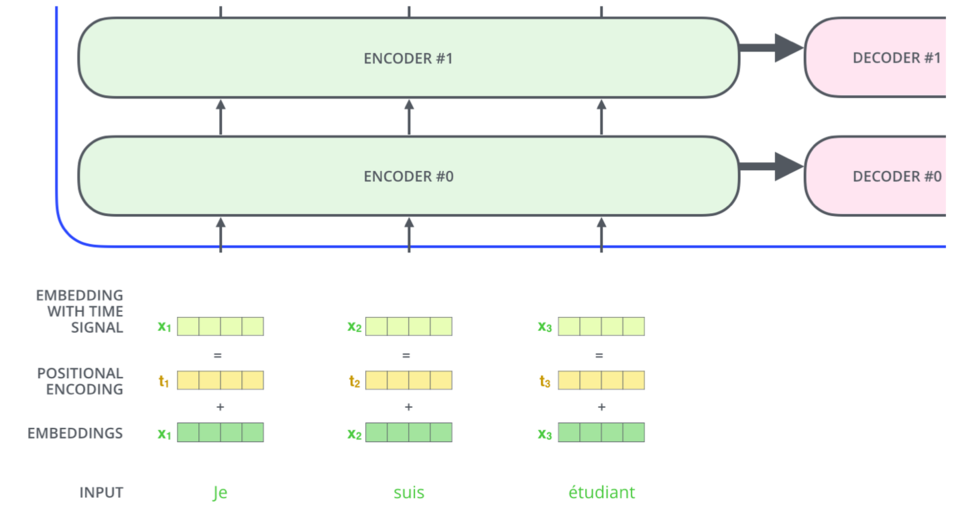

Positional Encoding 是一种考虑输入序列中单词顺序的方法。论文中的计算方式为：

[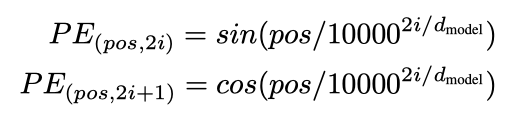](https://cdn.kesci.com/upload/image/puvu28syam.png?imageView2/0/w/960/h/960)
其中 pos 表示位置index， i 表示dimension index。

encoder 为每个输入 embedding 添加了一个向量，这些向量符合一种特定模式，可以确定每个单词的位置，或者序列中不同单词之间的距离。

在下图中，是20个单词的 positional encoding，每行代表一个单词的位置编码，即第一行是加在输入序列中第一个词嵌入的，每行包含 512 个值， 每个值介于 -1 和 1 之间，用颜色表示出来。

[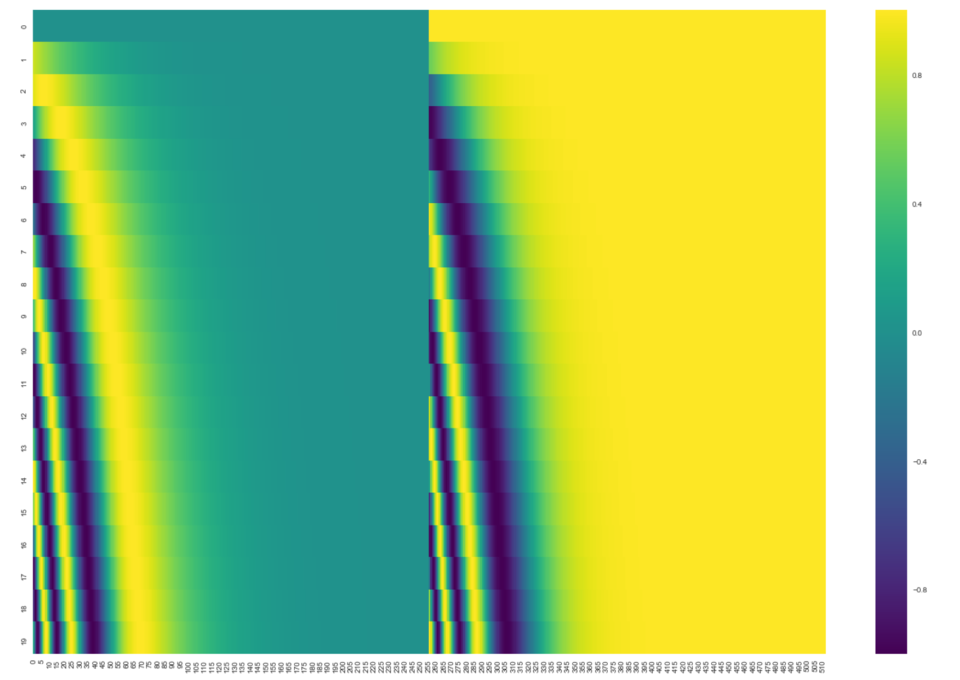](https://cdn.kesci.com/upload/image/puvs6an48x.png?imageView2/0/w/960/h/960)


In [7]:
def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return torch.FloatTensor(sinusoid_table)

3.mask

mask的作用主要是为了在计算Attention的时候，让模型看不到未来的信息。

[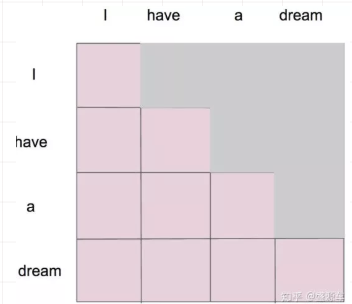](https://cdn.kesci.com/upload/image/puvsf1ygx1.png?imageView2/0/w/960/h/960)

例如，对于I，只有其与自身的Attention。对于第二个单词have，有其与I和自身的两个Attention。


In [8]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)
    return pad_attn_mask.expand([batch_size, len_q, len_k])

In [9]:
def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask

4.计算Attention

我们使用Q和K来计算Attention，并且通过softmax来归一化。之后和V相乘。

[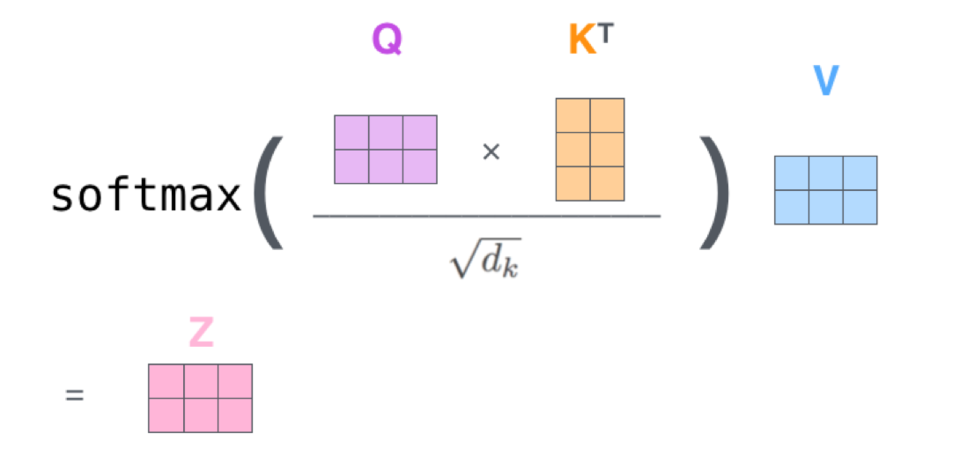](https://cdn.kesci.com/upload/image/puvsy7nykw.png?imageView2/0/w/960/h/960)


In [10]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

![img](https://pic4.zhimg.com/80/v2-15f871fac203f20a87d7ab067549833b_720w.jpg)



图1 Attention机制的本质思想

我们可以这样来看待Attention机制（参考图1）： 将Source中的构成元素想象成是由一系列的<Key,Value>数据对构成，此时给定Target中的某个元素Query，通过计算Query和各个Key的相似性或者相关性，得到每个Key对应Value的权重系数，然后对Value进行加权求和，即得到了最终的Attention数值。所以本质上Attention机制是对Source中元素的Value值进行加权求和，而Query和Key用来计算对应Value的权重系数。即可以将其本质思想改写为如下公式：

![img](https://pic4.zhimg.com/80/v2-56af9b2c9d8e39e632cbd4e444870927_720w.jpg)

上文所举的机器翻译的例子里，因为在计算Attention的过程中，Source中的Key和Value合二为一，指向的是同一个东西，也即输入句子中每个单词对应的语义编码，所以可能不容易看出这种能够体现本质思想的结构。
当然，从概念上理解，把Attention仍然理解为从大量信息中有选择地筛选出少量重要信息并聚焦到这些重要信息上，忽略大多不重要的信息，这种思路仍然成立。聚焦的过程体现在权重系数的计算上，权重越大越聚焦于其对应的Value值上，即权重代表了信息的重要性，而Value是其对应的信息。
**从图1可以引出另外一种理解，也可以将Attention机制看作一种软寻址（Soft Addressing）:**
**Source可以看作存储器内存储的内容，元素由地址Key和值Value组成，当前有个Key=Query的查询，目的是取出存储器中对应的Value值，即Attention数值。通过Query和存储器内元素Key的地址进行相似性比较来寻址，之所以说是软寻址，指的不像一般寻址只从存储内容里面找出一条内容，而是可能从每个Key地址都会取出内容，取出内容的重要性根据Query和Key的相似性来决定，之后对Value进行加权求和，这样就可以取出最终的Value值，也即Attention值。所以不少研究人员将Attention机制看作软寻址的一种特例，这也是非常有道理的。**
**至于Attention机制的具体计算过程，如果对目前大多数方法进行抽象的话，可以将其归纳为两个过程：第一个过程是根据Query和Key计算权重系数，第二个过程根据权重系数对Value进行加权求和。而第一个过程又可以细分为两个阶段：第一个阶段根据Query和Key计算两者的相似性或者相关性；第二个阶段对第一阶段的原始分值进行归一化处理；这样，可以将Attention的计算过程抽象为三个阶段。**





**![img](https://pic3.zhimg.com/80/v2-ae1625293164d0ec41cfc0be7487b0ba_720w.jpg)**



5.MultiHeadAttention

由于我们采用了Multihead，我们会得到和 heads 数目一样多的 Query / Key / Value 权重矩阵组。论文中使用了8个。

[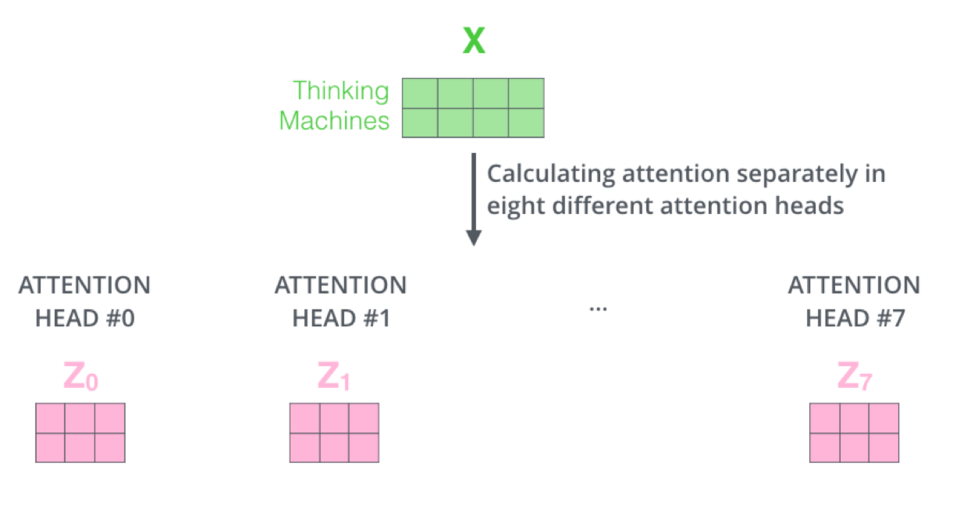](https://cdn.kesci.com/upload/image/puvt2c49ku.png?imageView2/0/w/960/h/960)

[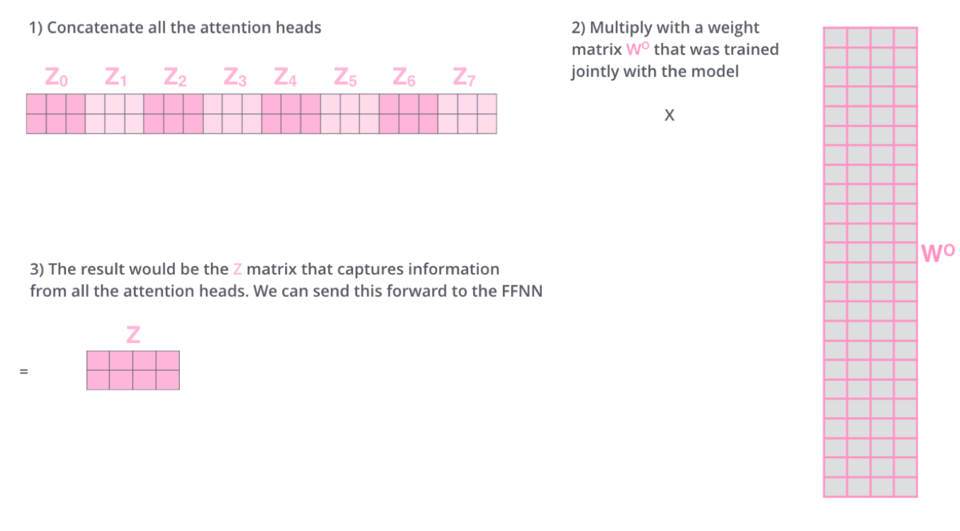](https://cdn.kesci.com/upload/image/puvt2kfadw.png?imageView2/0/w/960/h/960)


In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]
        print(attn_mask.size())
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]
        print(attn_mask.size())
        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(n_heads * d_v, d_model)(context)
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]


6.PoswiseFeedForwardNet

在进行了Attention操作之后，encoder和decoder中的每一层都包含了一个全连接前向网络，对每个position的向量分别进行相同的操作，包括两个线性变换和一个ReLU激活输出：
公式为： $FFN(x) = max(0, xW_1+b_1)W_2+b_2$


In [12]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return nn.LayerNorm(d_model)(output + residual)


7.EncoderLayer

Encoder有N=6层，每层包括两个部分:

第一个部分是multi-head self-attention mechanism，用来计算输入的self-attention

第二个部分是简单的全连接网络，即之前的PoswiseFeedForwardNet。

在每个部件中我们都使用了残差网络，即：LayerNorm(x+Sublayer(x))


[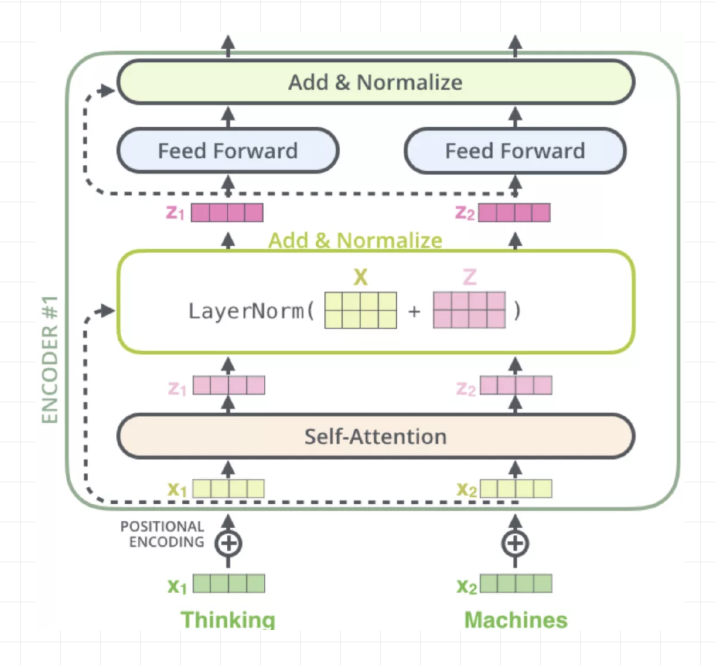](https://cdn.kesci.com/upload/image/puvtei5tq0.png?imageView2/0/w/960/h/960)


In [13]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

8.DecoderLayer

Decoder也是N=6层，每层包括3个部件：

第一个部件是Masked multi-head self-attention，也是计算输入的self-attention，但是因为是生成过程，因此在时刻i的时候，大于i的时刻都没有结果，只有小于i的时刻有结果，因此需要做Mask。

第二个部件是全连接网络，与Encoder相同

第三个部件是对encoder的输入进行attention计算。

同时Decoder中的self-attention层需要进行修改，因为只能获取到当前时刻之前的输入，因此只对时刻 t 之前的时刻输入进行attention计算，这也称为Mask操作。

[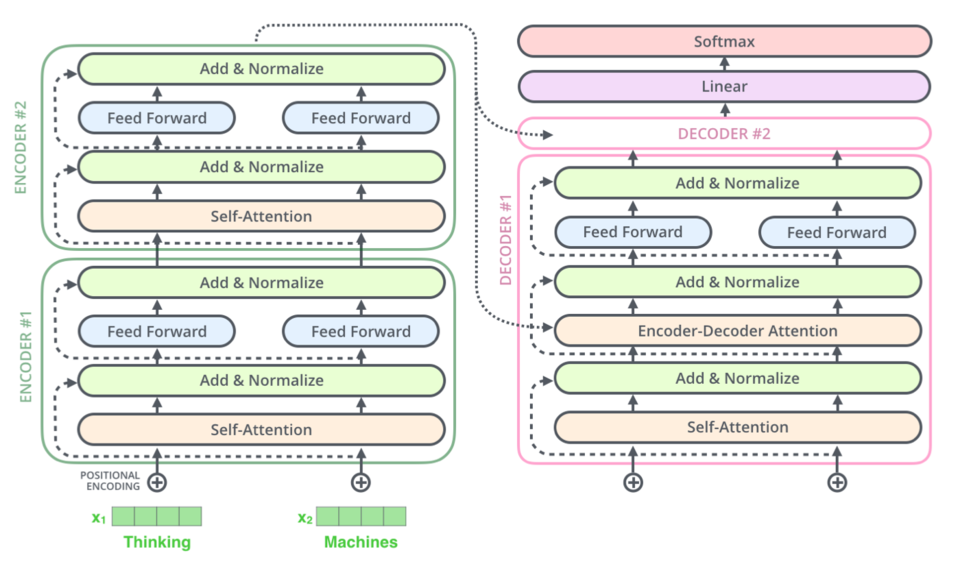](https://cdn.kesci.com/upload/image/puvtjskvbb.png?imageView2/0/w/960/h/960)


In [14]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

9.Encoder和Decoder

论文中使用了6个encoderlayer和6个decoderlayer，所以我们将他们叠起来。

In [15]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs): # enc_inputs : [batch_size x source_len]
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

In [16]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(torch.LongTensor([[5,1,2,3,4]]))
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

10.Transformer

最后我们得到了最后的模型。

In [17]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns


## 四. 模型的训练
下面对于进行模型的训练，对我们的那一句话进行训练。

In [18]:
model = Transformer()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [19]:
for epoch in range(20):
    optimizer.zero_grad()
    enc_inputs, dec_inputs, target_batch = make_batch(sentences)
    outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
    loss = criterion(outputs, target_batch.contiguous().view(-1))
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
Epoch: 0001 cost = 2.375202
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size

torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
Epoch: 0011 cost = 0.001318
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size

## 五. 预测和Attention的展示
下面我们展示了Encoder-Attention，Decoder-Attention和Encoder-Decoder-Attention。

torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
torch.Size([1, 5, 5])
torch.Size([1, 8, 5, 5])
ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']
first head of last state enc_self_attns


C:\Users\Harri\AppData\Local\Temp/ipykernel_4580/650875752.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
C:\Users\Harri\AppData\Local\Temp/ipykernel_4580/650875752.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})


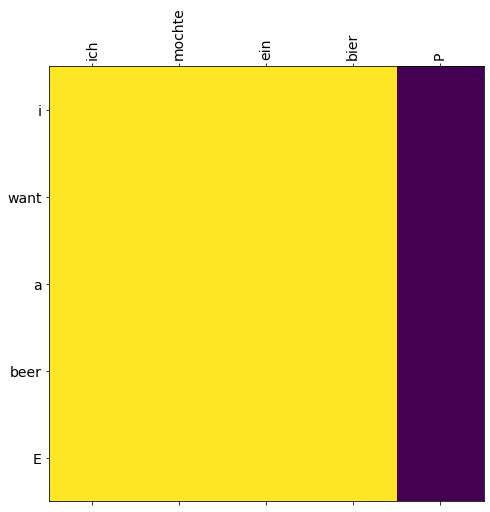

first head of last state dec_self_attns


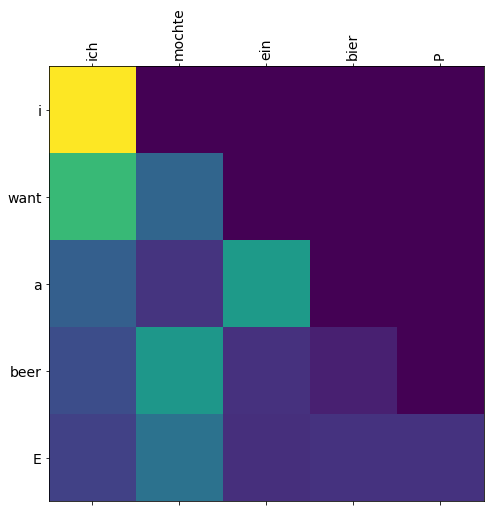

first head of last state dec_enc_attns


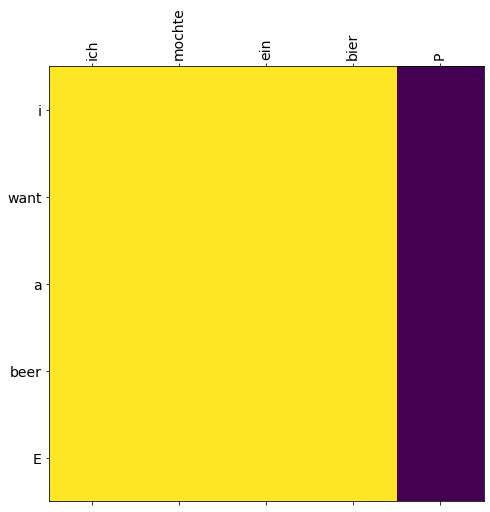

In [20]:
# Test
predict, _, _, _ = model(enc_inputs, dec_inputs)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

def showgraph(attn):
    attn = attn[-1].squeeze(0)[0]
    attn = attn.squeeze(0).data.numpy()
    fig = plt.figure(figsize=(n_heads, n_heads)) # [n_heads, n_heads]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()


print('first head of last state enc_self_attns')
showgraph(enc_self_attns)

print('first head of last state dec_self_attns')
showgraph(dec_self_attns)

print('first head of last state dec_enc_attns')
showgraph(dec_enc_attns)

## 六. 参考
https://colab.research.google.com/github/graykode/nlp-tutorial/blob/master/5-1.Transformer/Transformer_Torch.ipynb#scrollTo=nNemnO18h6PV

https://jalammar.github.io/illustrated-transformer/